In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [9]:
def encoded_pixels_to_masks(fname: str, df: pd.DataFrame):
    fname_df = df[df['ImageId'] == fname]
    masks = np.zeros((256 * 1600, 4), dtype=int) # float32 is V.Imp

    for i_row, row in fname_df.iterrows():
        cls_id = row['ClassId']
        encoded_pixels = row['EncodedPixels']
        if encoded_pixels is not np.nan:
            pixel_list = list(map(int, encoded_pixels.split(' ')))
            for i in range(0, len(pixel_list), 2):
                start_pixel = pixel_list[i] - 1
                num_pixel = pixel_list[i+1]
                masks[start_pixel:(start_pixel+num_pixel), cls_id-1] = 1
                
    masks = masks.reshape(256, 1600, 4, order='F')

    return masks

def masks_to_encoded_pixels(masks: np.ndarray):
    masks = masks.reshape(256*1600, 4, order='F')
    encoded_pixels_list = []
    for cls_id in range(4):
        cls_mask = masks[:, cls_id]
        cls_mask = cls_mask.reshape(256, 1600, order='F')
        cls_mask = cls_mask.T.flatten()
        prev_pixel = 0
        prev_pixel_val = 0
        encoded_pixels = []
        for i, pixel_val in enumerate(cls_mask):
            if pixel_val != prev_pixel_val:
                if pixel_val == 1:
                    start_pixel = i + 1
                    encoded_pixels.append(start_pixel - prev_pixel)
                else:
                    num_pixel = i - prev_pixel
                    encoded_pixels.append(num_pixel)
                prev_pixel = i
                prev_pixel_val = pixel_val
        encoded_pixels_list.append(encoded_pixels)
    return encoded_pixels_list # shape: 4x[]

### Sample example

In [10]:
train_val_csv = '../train.csv'

df = pd.read_csv(train_val_csv)

df.ImageId

0       0002cc93b.jpg
1       0007a71bf.jpg
2       000a4bcdd.jpg
3       000f6bf48.jpg
4       0014fce06.jpg
            ...      
7090    ffcf72ecf.jpg
7091    fff02e9c5.jpg
7092    fffe98443.jpg
7093    ffff4eaa8.jpg
7094    ffffd67df.jpg
Name: ImageId, Length: 7095, dtype: object

In [11]:
# let's look at encoded pixels for the first image
img_id = '0002cc93b.jpg'
df[df.ImageId==img_id]

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...


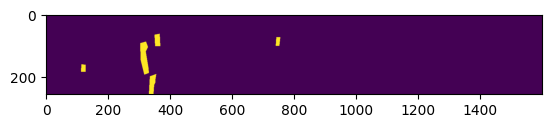

In [12]:
masks = encoded_pixels_to_masks(img_id, df, )
plt.imshow(masks[:,:,0]*255)

In [17]:
img = Image.open(os.path.join('../train_images',img_id))

In [18]:
np.array(img).shape

(256, 1600, 3)

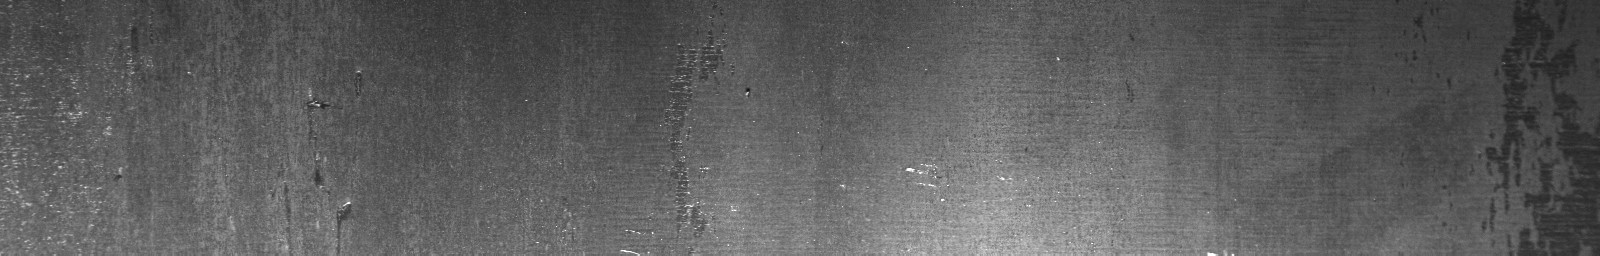

In [19]:
img

In [20]:
# let's encode masks back to encoded pixels
np.array(masks_to_encoded_pixels(masks)[0])

array([29102,    12,   233,    24,   233,    24,   233,    24,   233,
          24,   233,    24,   233,    24,   233,    24,   234,    23,
         234,    23,   234,    23,   234,    23,   234,    23,   234,
          23,   234,    23, 45221,    27,   230,    55,   201,    60,
         197,    64,   193,    68,   189,    72,   184,    77,   180,
          81,   176,    85,   172,    89,   167,    94,   163,    98,
         159,   102,   154,   105,   152,   105,   152,   104,   153,
         104,   152,   105,   152,    31,     5,    69,   155,    27,
          13,    63,   158,    22,    21,    57,   161,    17,    29,
          50,   164,    13,    37,    44,   167,     8,    45,    37,
         171,     3,    53,    31,   232,    25,   238,    18,   249,
           8,   314,    10,   228,    29,   210,    47,   200,    57,
         200,    57,   199,    58,   199,    58,   199,    58,   198,
          59,   198,    59,   198,    59,   197,    60,   197,    60,
         197,    60,

### Your code starts from here

In [21]:
class SeverstalSteelDataset(Dataset):
    def __init__(self, fnames, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.fnames = fnames
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img) / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        masks = encoded_pixels_to_masks(fname, self.df)
        masks = torch.tensor(masks, dtype=torch.float32).permute(2, 0, 1)

        if self.transform:
            img = self.transform(img)

        return fname, img, masks
    
# collate function if needed
def collate_fn(batch_items):
    batched_fnames = []
    batched_imgs = []
    batched_masks = []
    
    for fname, img, masks in batch_items:
        batched_fnames.append(fname)
        batched_imgs.append(img)
        batched_masks.append(masks)
    
    batched_imgs = torch.stack(batched_imgs, dim=0)
    batched_masks = torch.stack(batched_masks, dim=0)
    
    return batched_fnames, batched_imgs, batched_masks
    

In [23]:
from torchvision import models
import segmentation_models_pytorch as smp

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()

        self.dice_loss = smp.losses.DiceLoss(mode='multilabel', from_logits=True, smooth=smooth)

    def forward(self, predicts, targets):
        return self.dice_loss(predicts, targets)

class BCEDiceLoss(torch.nn.Module):
    def __init__(self, alpha, beta):
        super().__init__()

        self.alpha = alpha
        self.bce_loss = torch.nn.BCEWithLogitsLoss()
        self.beta = beta
        self.dice_loss = DiceLoss()

    def forward(self, predicts, targets):
        return self.alpha * self.bce_loss(predicts, targets) + self.beta * self.dice_loss(predicts, targets)

class SegModel(torch.nn.Module):
    def __init__(self):
        super(SegModel, self).__init__()
        
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=1,
            classes=4)

    def forward(self, x):
        return self.model(x)

In [27]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def load_data(train_val_csv, test_csv, train_val_img_dir, test_img_dir):
    train_val_df = pd.read_csv(train_val_csv)
    train_val_fnames = pd.unique(df.ImageId)
    # test_df = pd.read_csv(test_csv)
    # test_fnames = pd.unique(test_df.ImageId)
        
    train_fnames, val_fnames = train_test_split(
        train_val_fnames, 
        test_size=0.2, 
        random_state=42,
        shuffle=True
    )
    
    train_dataset = SeverstalSteelDataset(
        fnames=train_fnames,
        df=train_val_df,
        img_dir=train_val_img_dir,
        transform=None
    )
    
    val_dataset = SeverstalSteelDataset(
        fnames=val_fnames,
        df=train_val_df,
        img_dir=train_val_img_dir,
        transform=None
    )
    
    # test_dataset = SeverstalSteelDataset(
    #     fnames=test_fnames,
    #     df=test_df,
    #     img_dir=test_img_dir,
    #     transform=None
    # )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )
    
    # test_loader = DataLoader(
    #     test_dataset,
    #     batch_size=32,
    #     shuffle=False,
    #     collate_fn=collate_fn,
    #     num_workers=4,
    #     pin_memory=True
    # )
    
    return train_loader, val_loader, None

In [28]:
from tqdm import tqdm

def init_model():
    model = SegModel()
    criterion = BCEDiceLoss(0.75, 0.25)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    return model, criterion, optimizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(model, criterion, optimizer, train_loader, validate_loader, epochs):
    model.to(device)
    model.train()

    best_epoch = 0
    val_best_loss = 1000
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for batch_idx, (fnames, images, masks) in enumerate(train_pbar):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            current_train_loss = train_loss / (batch_idx + 1)
            train_pbar.set_postfix({'loss': f'{current_train_loss:.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss_total = 0
        with torch.no_grad():
            for _, val_imgs, val_masks in validate_loader:
                    val_imgs, val_masks = val_imgs.to(device), val_masks.to(device)
                    val_outputs = model(val_imgs)
                    val_loss = criterion(val_outputs, val_masks).item()
                    val_loss_total += val_loss.item()

        avg_val_loss = val_loss_total / len(validate_loader)    
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        if avg_val_loss < val_best_loss or val_best_loss == 1000:
             best_model_state = model.state_dict()
             best_epoch = epoch

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Best epoch: {best_epoch}; best loss on validate dataset: {val_best_loss}")
    
    return model

In [31]:
train_loader, validate_loader, _ = load_data("../train.csv", "", "../train_images", "")

In [32]:
model, criterion, optimizer = init_model()

In [33]:
train(model, criterion, optimizer, train_loader, validate_loader, 100)

Epoch 1/100 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]/Users/skuralenok/sk4/education/DL_HSE_2025_fall/homeworks/hw2/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=94, pipe_handle=115)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
Attr

KeyboardInterrupt: 